In [47]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [48]:
#Load Datasets

## load Cleaned Data
cleaned_data = pd.read_csv("cleaned_data.csv", index_col="GEOID")
cleaned_data.index = cleaned_data.index.astype(int)

#load geospatial data
tracts_geodata = gpd.read_file("tracts.geojson")
tracts_geodata = tracts_geodata.set_index("GEOID")
tracts_geodata.index = tracts_geodata.index.astype(int)

/var/folders/67/r87g720s2653g554zdhtz1vh0000gn/T/ipykernel_51087/1928580862.py:4: DtypeWarning: Columns (181) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_data = pd.read_csv("cleaned_data.csv", index_col="GEOID")


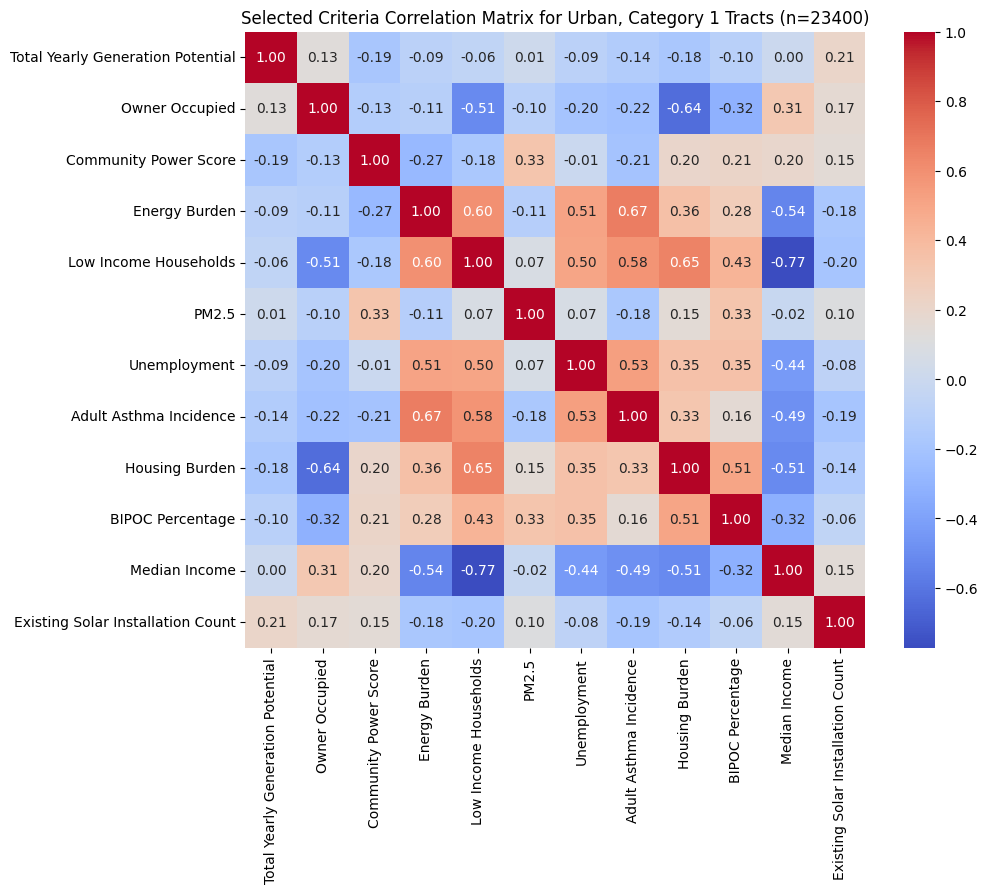

In [51]:
#Correlation Matrix
criteria = ['yearly_sunlight_kwh_total', 'owner_occupied', 'community_power_score', 
             'energy_burden', 'Percent of individuals below 200% Federal Poverty Line',
             'PM2.5 in the air', 'Unemployment (percent)', 
             'Current asthma among adults aged greater than or equal to 18 years']

comparison_criteria = ['Housing burden (percent)', "bipoc_percent", "median_income", "existing_installs_count"]

correlation_matrix = cleaned_data[criteria + comparison_criteria].corr()
labels = ['Total Yearly Generation Potential', 'Owner Occupied', 'Community Power Score', 
             'Energy Burden', 'Low Income Households','PM2.5', 'Unemployment', 
             'Adult Asthma Incidence', 
             'Housing Burden', "BIPOC Percentage", "Median Income", "Existing Solar Installation Count"]

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=labels, yticklabels=labels )
plt.title("Selected Criteria Correlation Matrix for Urban, Category 1 Tracts (n=23400)")
plt.show()

In [123]:
#Normalize Data

criteria = ['yearly_sunlight_kwh_total', 'owner_occupied', 'community_power_score']

normalized_data = cleaned_data.copy()

#minmax normalization
for criterion in criteria:
    normalized_data[criterion] = normalized_data[criterion] / (normalized_data[criterion].max() - normalized_data[criterion].min())


In [149]:
#MCDA for Feasibility, Impact, Co-Benefits

weights_feasibility = {
    'yearly_sunlight_kwh_total': 0.4,
    'owner_occupied': 0.35,
    'community_power_score': 0.25,
}

weights_impact = {
    'Energy burden (percentile)': 0.4,
    'Percent of individuals below 200% Federal Poverty Line (percentile)': 0.2,
    'Unemployment (percent) (percentile)': 0.2,
    'PM2.5 in the air (percentile)': 0.2
}

mcda_output = pd.DataFrame()

# Perform the weighted sum calculation
mcda_output['feasibility_score'] = (normalized_data[list(weights_feasibility.keys())] * list(weights_feasibility.values())).sum(axis=1)
mcda_output['impact_score'] = (normalized_data[list(weights_impact.keys())]/100 * list(weights_impact.values())).sum(axis=1)
mcda_output['total_score'] = mcda_output['feasibility_score'] + mcda_output['impact_score']

# Categorize the scores
# bins = [0, 0.33, 0.67, 1]
labels = ['low', 'med', 'high']
mcda_output['feasibility_potential'] = pd.cut(mcda_output['feasibility_score'], bins=3, labels=labels, include_lowest=True)
mcda_output['impact_potential'] = pd.cut(mcda_output['impact_score'], bins=3, labels=labels, include_lowest=True)
mcda_output['total_potential'] = pd.cut(mcda_output['total_score'], bins=3, labels=labels, include_lowest=True)

##Q: How does the binning work? Important to understand the results
print(mcda_output.head)

<bound method NDFrame.head of              feasibility_score  impact_score  total_score   
GEOID                                                       
53067010600           0.310231         0.430     0.740231  \
53067011500           0.345077         0.452     0.797077   
53067011300           0.257457         0.402     0.659457   
53067011200           0.223722         0.400     0.623722   
53067010920           0.334236         0.412     0.746236   
...                        ...           ...          ...   
6071007408            0.382718         0.742     1.124718   
6071007409            0.525513         0.620     1.145513   
6071007410            0.387099         0.614     1.001099   
6071007303            0.303377         0.694     0.997377   
6071003404            0.370126         0.674     1.044126   

            feasibility_potential impact_potential total_potential  
GEOID                                                               
53067010600                   med     

In [184]:
#get summary statistics
print(mcda_output['feasibility_potential'].value_counts())
print(mcda_output['impact_potential'].value_counts())


print(mcda_output['feasibility_score'].describe())
print(mcda_output['impact_score'].describe())
print(mcda_output['total_score'].describe())

feasibility_potential
med     16415
low      3809
high     3176
Name: count, dtype: int64
impact_potential
med     12602
high     7618
low      3180
Name: count, dtype: int64
count    23400.000000
mean         0.328407
std          0.103527
min          0.006754
25%          0.259468
50%          0.326109
75%          0.398146
max          0.667503
Name: feasibility_score, dtype: float64
count    23400.000000
mean         0.591117
std          0.178768
min          0.090000
25%          0.458000
50%          0.586000
75%          0.728000
max          0.978000
Name: impact_score, dtype: float64
count    23400.000000
mean         0.919524
std          0.176353
min          0.298842
25%          0.799747
50%          0.927033
75%          1.047139
max          1.486471
Name: total_score, dtype: float64


In [158]:
#Look at Top 10 tracts for feasibility, impact, cobenefits, total

#Merge larger dataset for more information on tracts
merged_mcda_output = cleaned_data.merge(mcda_output, left_index=True, right_index=True)[["state_abbr", "county_name", "feasibility_score", "impact_score", "total_score"]]

print("Top 10 Tracts Overall")
print(merged_mcda_output.nlargest(10, 'total_score')[["state_abbr", "county_name", "feasibility_score", "impact_score", "total_score"]])

print("Top 10 Tracts for Feasibility:")
print(merged_mcda_output.nlargest(10, 'feasibility_score')[["state_abbr", "county_name", "feasibility_score"]])

print("Top 10 Tracts for Impact:")
print(merged_mcda_output.nlargest(20, 'impact_score')[["state_abbr", "county_name", "impact_score", "feasibility_score"]])



top_ten_impact_low_feasibility = merged_mcda_output.nlargest(30, 'impact_score').nsmallest(30, 'feasibility_score')
print(top_ten_impact_low_feasibility)

#Map these next to cities


Top 10 Tracts Overall
            state_abbr         county_name  feasibility_score  impact_score   
GEOID                                                                         
6019001500          CA       Fresno County           0.556471         0.930  \
17031671400         IL         Cook County           0.501447         0.938   
6099002302          CA   Stanislaus County           0.477097         0.940   
17163502200         IL    St. Clair County           0.461816         0.944   
36005033400         NY        Bronx County           0.596013         0.804   
17163501300         IL    St. Clair County           0.537979         0.860   
6077003803          CA  San Joaquin County           0.589900         0.806   
29189213102         MO    St. Louis County           0.564819         0.830   
17163501200         IL    St. Clair County           0.496850         0.896   
6029001500          CA         Kern County           0.414599         0.978   

             total_score  
GE

In [190]:
#Write mcda output to use for further analysis
merged_mcda_output.to_csv('mcda_output.csv', index=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


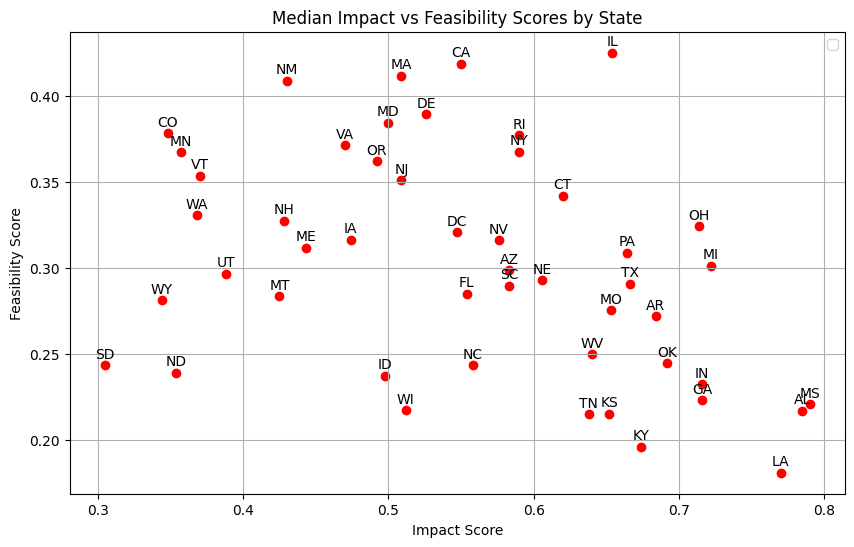

In [199]:
#Graph Impact Scores vs Median Emissions for State (because some states are overrepresented in the data)
state_median = merged_mcda_output.groupby('state_abbr')[['impact_score', 'feasibility_score']].median()

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(state_median['impact_score'], state_median['feasibility_score'], c='red', marker='o')

# Set labels, title, and legend
plt.xlabel('Impact Score')
plt.ylabel('Feasibility Score')
plt.title('Median Impact vs Feasibility Scores by State')
plt.legend()

# Annotate points with state names
for i, state in enumerate(state_median.index):
    plt.annotate(state, (state_median['impact_score'][i], state_median['feasibility_score'][i]),
                 textcoords="offset points", xytext=(0, 5), ha='center')

plt.grid(True)
plt.show()

In [171]:
#Top scores by state
# Group the data by states and calculate the sum of feasibility scores
state_feasibility = merged_mcda_output.groupby('state_abbr')['feasibility_score']

# Get the top 10 states with the highest median feasibility scores
print(state_feasibility.median().nlargest(10))

# Group the data by states and calculate the sum of impact scores
state_impact = merged_mcda_output.groupby('state_abbr')['impact_score']

# Get the top 10 states with the highest median impact scores
print(state_impact.median().nlargest(10))

# Group the data by states and calculate the total scores
state_total = merged_mcda_output.groupby('state_abbr')['total_score']

# Get the top 10 states with the highest median impact scores
print(state_total.median().nlargest(10))

state_abbr
IL    0.425157
CA    0.418875
MA    0.411802
NM    0.408865
DE    0.389509
MD    0.384558
CO    0.378531
RI    0.377081
VA    0.371261
NY    0.367710
Name: feasibility_score, dtype: float64
state_abbr
MS    0.790
AL    0.785
LA    0.770
MI    0.722
IN    0.716
GA    0.716
OH    0.714
OK    0.692
AR    0.684
KY    0.674
Name: impact_score, dtype: float64
state_abbr
IL    1.095227
OH    1.037711
MI    1.026117
MS    1.004121
AL    1.003332
PA    0.982347
NY    0.980136
CT    0.978244
AR    0.975842
CA    0.971684
Name: total_score, dtype: float64


In [ ]:
# Box and Whisker for 
states_to_compare = ['MS', 'AL', 'LA', 'MI', 'IN', 'GA', 'OH', 'OK', 'AR', 'KY']

# Filter the data for the selected states
data_to_plot = [merged_mcda_output[merged_mcda_output['state_abbr'] == state]['impact_score'] for state in states_to_compare]

# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Custom box plot colors
# box_plot_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot the box plot for each state with custom colors
box_plot = ax.boxplot(data_to_plot, labels=states_to_compare, patch_artist=True)

# # Set individual colors for each box
# for patch, color in zip(box_plot['boxes'], box_plot_colors):
#     patch.set_facecolor(color)
patch.set_facecolor('#1f77b4')
# Customize gridlines
ax.yaxis.grid(True)
ax.set_axisbelow(True)

# Set labels, title, and font size
plt.xlabel('State', fontsize=12)
plt.ylabel('Impact Score', fontsize=12)
plt.title('Median Impact Score Distribution for Top 10 States', fontsize=14)

# Customize font size for tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

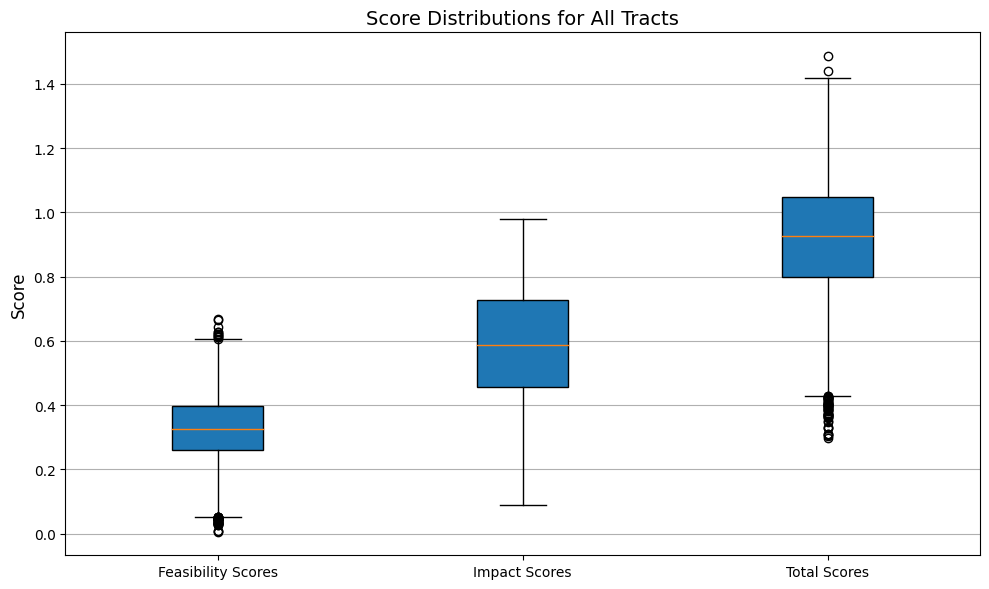

In [204]:
# Map feasibility, impact, total score data
states_to_compare = ['IL', 'CA', 'MA', 'NM', 'DE', 'MD', 'CO', 'RI', 'VA', 'NY']

# Filter the data for the selected states
data_to_plot = [merged_mcda_output[merged_mcda_output['state_abbr'] == state]['feasibility_score'] for state in states_to_compare]

# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Custom box plot colors
# box_plot_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot the box plot for each state with custom colors
box_plot = ax.boxplot([mcda_output['feasibility_score'], mcda_output['impact_score'], mcda_output['total_score']], labels=['Feasibility Scores','Impact Scores', 'Total Scores'], patch_artist=True)

# # Set individual colors for each box
# for patch, color in zip(box_plot['boxes'], box_plot_colors):
#     patch.set_facecolor(color)

# Customize gridlines
ax.yaxis.grid(True)
ax.set_axisbelow(True)

# Set labels, title, and font size
plt.ylabel('Score', fontsize=12)
plt.title('Score Distributions for All Tracts', fontsize=14)

# Customize font size for tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()





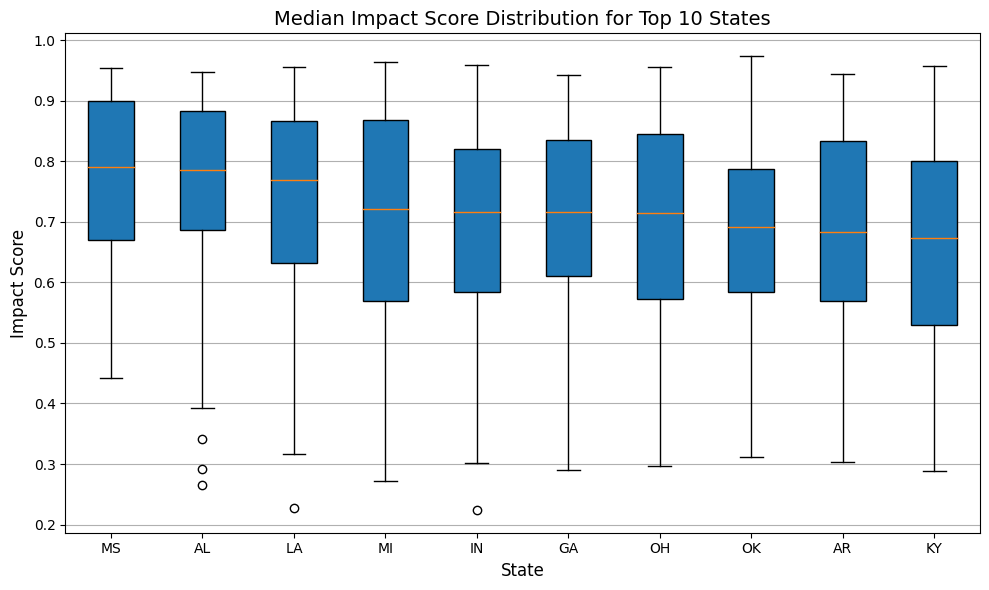

In [139]:
# Map state by state feasibility score data
states_to_compare = ['MS', 'AL', 'LA', 'MI', 'IN', 'GA', 'OH', 'OK', 'AR', 'KY']

# Filter the data for the selected states
data_to_plot = [merged_mcda_output[merged_mcda_output['state_abbr'] == state]['impact_score'] for state in states_to_compare]

# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Custom box plot colors
# box_plot_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot the box plot for each state with custom colors
box_plot = ax.boxplot(data_to_plot, labels=states_to_compare, patch_artist=True)

# # Set individual colors for each box
# for patch, color in zip(box_plot['boxes'], box_plot_colors):
#     patch.set_facecolor(color)
patch.set_facecolor('#1f77b4')
# Customize gridlines
ax.yaxis.grid(True)
ax.set_axisbelow(True)

# Set labels, title, and font size
plt.xlabel('State', fontsize=12)
plt.ylabel('Impact Score', fontsize=12)
plt.title('Median Impact Score Distribution for Top 10 States', fontsize=14)

# Customize font size for tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()





In [154]:
#Merge geometry attributes with mcda output
mcda_output['feasibility_potential'] = mcda_output['feasibility_potential'].astype(str)
mcda_output['impact_potential'] = mcda_output['impact_potential'].astype(str)
mcda_output['total_potential'] = mcda_output['total_potential'].astype(str)
mcda_geodata = tracts_geodata.merge(mcda_output, left_index=True, right_index=True)

#Print geometry data to file
mcda_geodata.to_file("mcda_tracts.geojson", driver='GeoJSON')

KeyboardInterrupt: 

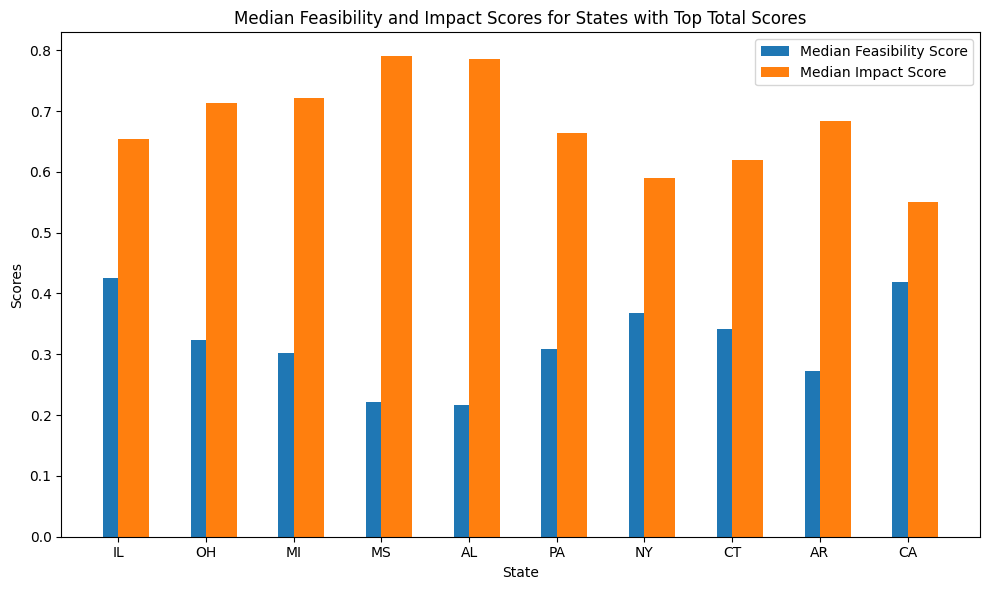

In [187]:
# Group the data by 'state_abbr' and calculate the median feasibility and impact scores
#top_states = ['IL', 'CA', 'MA', 'NM', 'DE', 'MD', 'CO', 'RI', 'VA', 'NY', 'MS', 'AL', 'LA', 'MI', 'IN', 'GA', 'OH', 'OK', 'AR', 'KY']

top_states_total = ['IL', 'OH', 'MI', 'MS', 'AL', 'PA', 'NY', 'CT', 'AR' ,'CA']

# Filter the data for the selected states
top_states_data = merged_mcda_output[merged_mcda_output['state_abbr'].isin(top_states_total)]

grouped_data = top_states_data.groupby('state_abbr')[['feasibility_score', 'impact_score', 'total_score']].median()

grouped_data = grouped_data.sort_values('total_score', ascending=False)

# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot the double bar graph
bar_width = 0.35
index = range(len(grouped_data))

ax.bar(index, grouped_data['feasibility_score'], bar_width, label='Median Feasibility Score')
ax.bar(index, grouped_data['impact_score'], bar_width, label='Median Impact Score', align='edge')

# Customize the plot
plt.xlabel('State')
plt.ylabel('Scores')
plt.title('Median Feasibility and Impact Scores for States with Top Total Scores')
plt.xticks(index, grouped_data.index)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


            feasibility_score  impact_score  total_score
state_abbr                                              
IL                   0.425157         0.654     1.095227
OH                   0.324210         0.714     1.037711
MI                   0.301416         0.722     1.026117
MS                   0.220858         0.790     1.004121
AL                   0.217107         0.785     1.003332
PA                   0.308927         0.664     0.982347
NY                   0.367710         0.590     0.980136
CT                   0.342036         0.620     0.978244
AR                   0.272205         0.684     0.975842
CA                   0.418875         0.550     0.971684


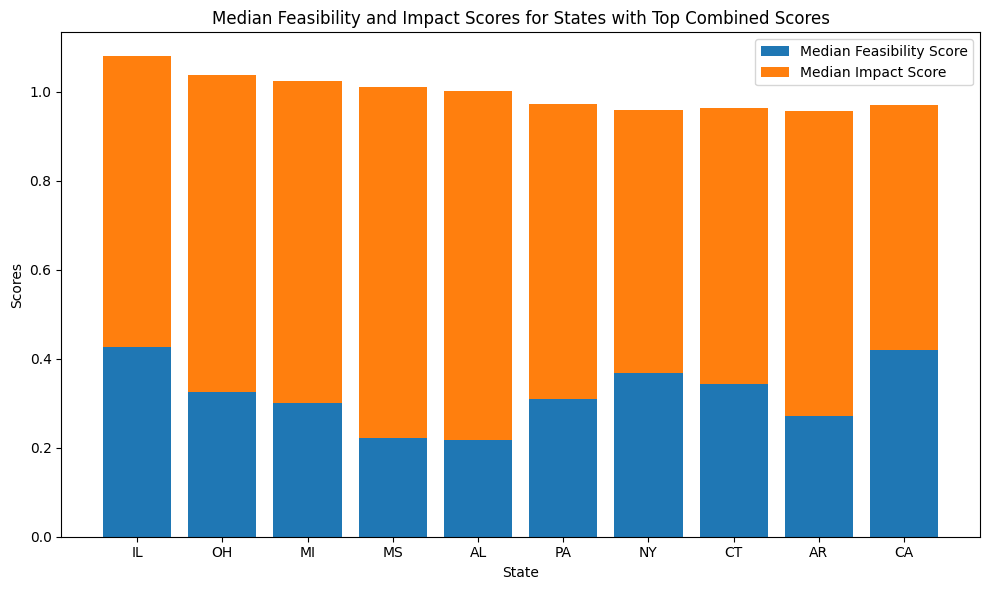

In [189]:
top_states_total = ['IL', 'OH', 'MI', 'MS', 'AL', 'PA', 'NY', 'CT', 'AR' ,'CA']

# Filter the data for the selected states
top_states_data = merged_mcda_output[merged_mcda_output['state_abbr'].isin(top_states_total)]

grouped_data = top_states_data.groupby('state_abbr')[['feasibility_score', 'impact_score', 'total_score']].median()

# Sort the DataFrame by total_score and get the top 10 rows
grouped_data = grouped_data.sort_values('total_score', ascending=False)
print(grouped_data)

# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot the stacked bar graph
bar_width = 0.8
index = range(len(grouped_data))

ax.bar(index, grouped_data['feasibility_score'], bar_width, label='Median Feasibility Score')
ax.bar(index, grouped_data['impact_score'], bar_width, bottom=grouped_data['feasibility_score'], label='Median Impact Score')

# Customize the plot
plt.xlabel('State')
plt.ylabel('Scores')
plt.title('Median Feasibility and Impact Scores for States with Top Combined Scores')
plt.xticks(index, grouped_data.index)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

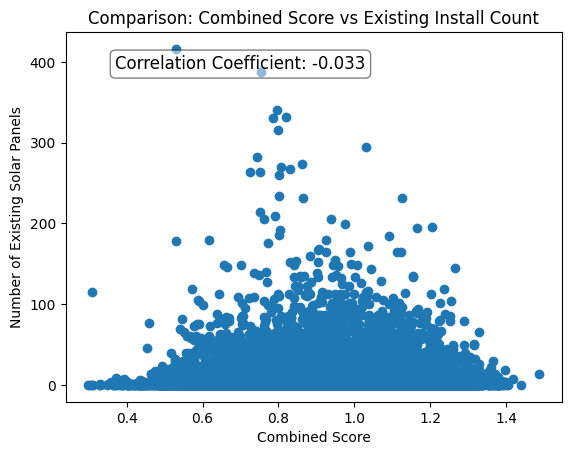

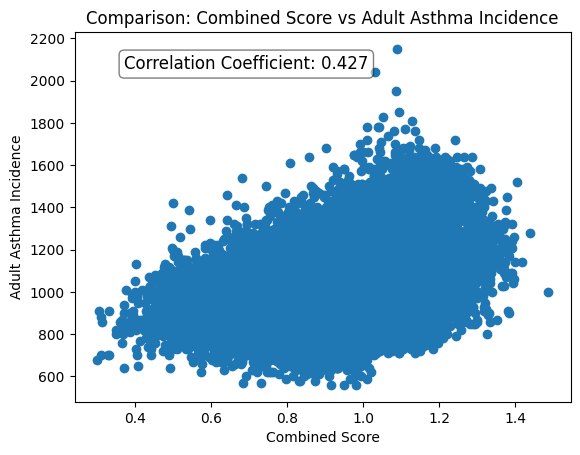

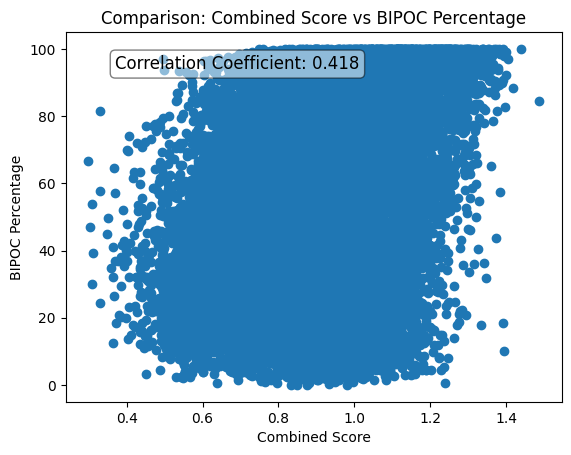

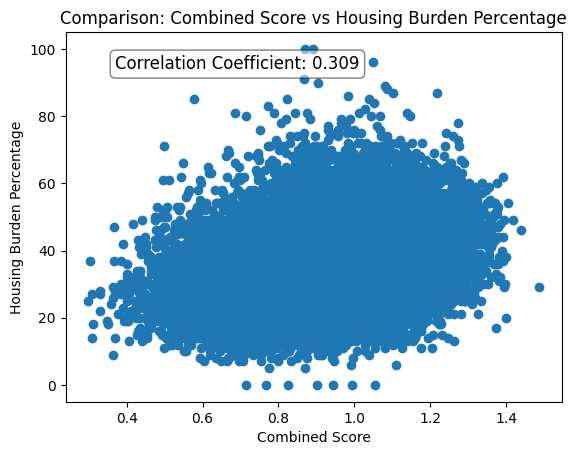

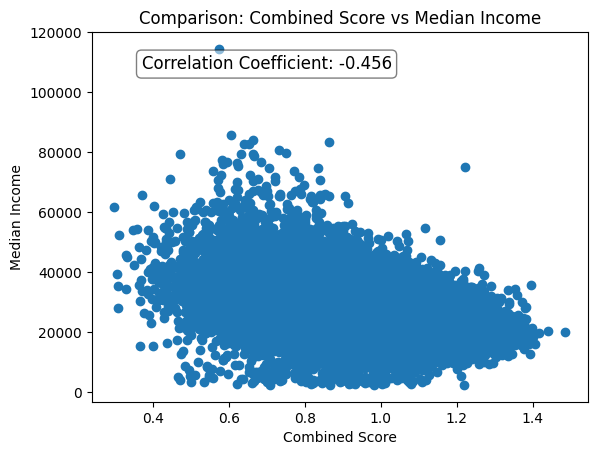

In [196]:
#Compare potential with Income, BIPOC, # of existing installs

# # Merge the mcda output data back into original dataframe
# mcda_data = merged_data.merge(mcda_output, left_index=True, right_index=True)

# Scatter plot of 'feasibility_score' vs 'existing_install_count'
plt.scatter(mcda_output['total_score'], cleaned_data['existing_installs_count'])
plt.xlabel('Combined Score')
plt.ylabel('Number of Existing Solar Panels')
plt.title('Comparison: Combined Score vs Existing Install Count')
correlation_coefficient = mcda_output['total_score'].corr(cleaned_data['existing_installs_count'])
# Annotate the plot with the correlation coefficient
plt.annotate(f"Correlation Coefficient: {correlation_coefficient:.3f}",
             xy=(0.1, 0.9),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.show()

plt.scatter(mcda_output['total_score'], cleaned_data['Current asthma among adults aged greater than or equal to 18 years'])
plt.xlabel('Combined Score')
plt.ylabel('Adult Asthma Incidence')
plt.title('Comparison: Combined Score vs Adult Asthma Incidence')
correlation_coefficient = mcda_output['total_score'].corr(cleaned_data['Current asthma among adults aged greater than or equal to 18 years'])
# Annotate the plot with the correlation coefficient
plt.annotate(f"Correlation Coefficient: {correlation_coefficient:.3f}",
             xy=(0.1, 0.9),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()


# Scatter plot of 'feasibility_score' vs 'bipoc_percent'
plt.scatter(mcda_output['total_score'], cleaned_data['bipoc_percent'])
plt.xlabel('Combined Score')
plt.ylabel('BIPOC Percentage')
plt.title('Comparison: Combined Score vs BIPOC Percentage')
correlation_coefficient = mcda_output['total_score'].corr(cleaned_data['bipoc_percent'])
plt.annotate(f"Correlation Coefficient: {correlation_coefficient:.3f}",
             xy=(0.1, 0.9),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()


plt.scatter(mcda_output['total_score'], cleaned_data['Housing burden (percent)'])
plt.xlabel('Combined Score')
plt.ylabel('Housing Burden Percentage')
plt.title('Comparison: Combined Score vs Housing Burden Percentage')
correlation_coefficient = mcda_output['total_score'].corr(cleaned_data['Housing burden (percent)'])
plt.annotate(f"Correlation Coefficient: {correlation_coefficient:.3f}",
             xy=(0.1, 0.9),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()

# Scatter plot of 'feasibility_score' vs 'median_income'
plt.scatter(mcda_output['total_score'], cleaned_data['median_income'])
plt.xlabel('Combined Score')
plt.ylabel('Median Income')
plt.title('Comparison: Combined Score vs Median Income')
correlation_coefficient = mcda_output['total_score'].corr(cleaned_data['median_income'])
plt.annotate(f"Correlation Coefficient: {correlation_coefficient:.3f}",
             xy=(0.1, 0.9),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()

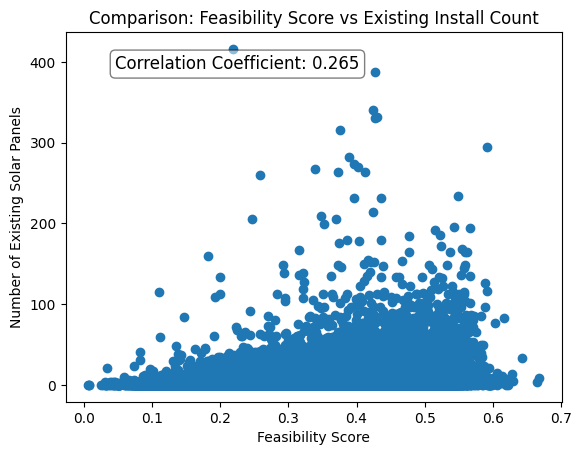

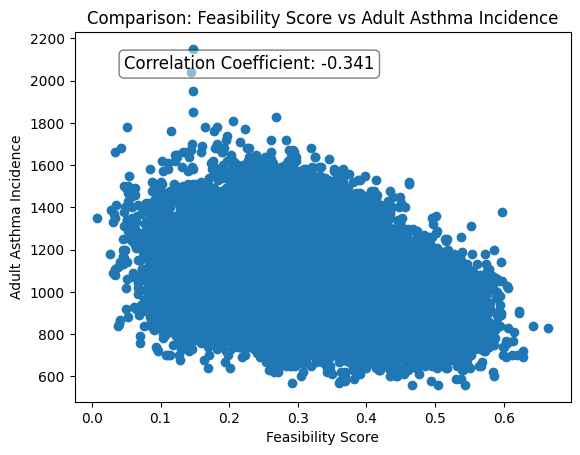

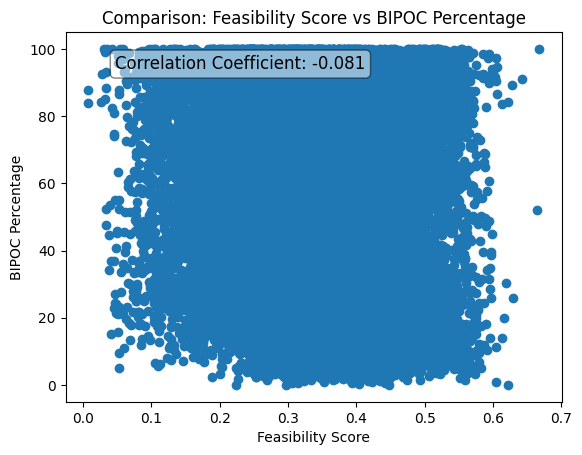

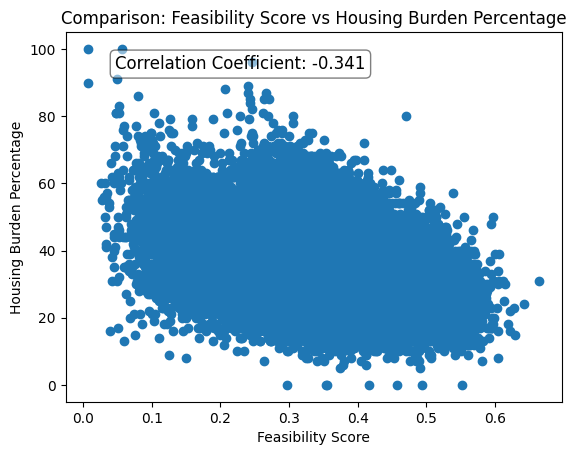

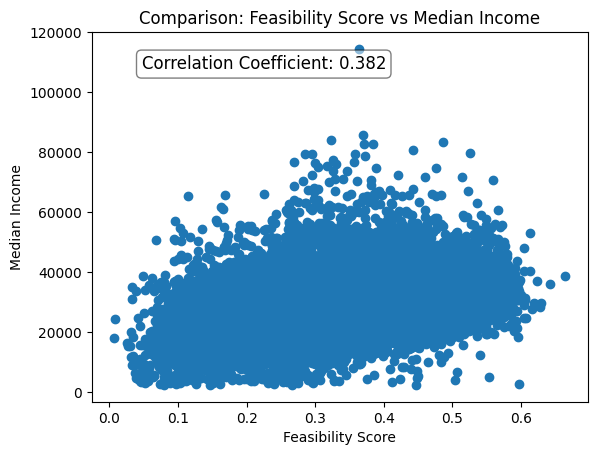

In [197]:
#Compare potential with Income, BIPOC, # of existing installs

# # Merge the mcda output data back into original dataframe
# mcda_data = merged_data.merge(mcda_output, left_index=True, right_index=True)

# Scatter plot of 'feasibility_score' vs 'existing_install_count'
plt.scatter(mcda_output['feasibility_score'], cleaned_data['existing_installs_count'])
plt.xlabel('Feasibility Score')
plt.ylabel('Number of Existing Solar Panels')
plt.title('Comparison: Feasibility Score vs Existing Install Count')
correlation_coefficient = mcda_output['feasibility_score'].corr(cleaned_data['existing_installs_count'])
# Annotate the plot with the correlation coefficient
plt.annotate(f"Correlation Coefficient: {correlation_coefficient:.3f}",
             xy=(0.1, 0.9),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.show()

plt.scatter(mcda_output['feasibility_score'], cleaned_data['Current asthma among adults aged greater than or equal to 18 years'])
plt.xlabel('Feasibility Score')
plt.ylabel('Adult Asthma Incidence')
plt.title('Comparison: Feasibility Score vs Adult Asthma Incidence')
correlation_coefficient = mcda_output['feasibility_score'].corr(cleaned_data['Current asthma among adults aged greater than or equal to 18 years'])
# Annotate the plot with the correlation coefficient
plt.annotate(f"Correlation Coefficient: {correlation_coefficient:.3f}",
             xy=(0.1, 0.9),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()


# Scatter plot of 'feasibility_score' vs 'bipoc_percent'
plt.scatter(mcda_output['feasibility_score'], cleaned_data['bipoc_percent'])
plt.xlabel('Feasibility Score')
plt.ylabel('BIPOC Percentage')
plt.title('Comparison: Feasibility Score vs BIPOC Percentage')
correlation_coefficient = mcda_output['feasibility_score'].corr(cleaned_data['bipoc_percent'])
plt.annotate(f"Correlation Coefficient: {correlation_coefficient:.3f}",
             xy=(0.1, 0.9),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()


plt.scatter(mcda_output['feasibility_score'], cleaned_data['Housing burden (percent)'])
plt.xlabel('Feasibility Score')
plt.ylabel('Housing Burden Percentage')
plt.title('Comparison: Feasibility Score vs Housing Burden Percentage')
correlation_coefficient = mcda_output['feasibility_score'].corr(cleaned_data['Housing burden (percent)'])
plt.annotate(f"Correlation Coefficient: {correlation_coefficient:.3f}",
             xy=(0.1, 0.9),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()

# Scatter plot of 'feasibility_score' vs 'median_income'
plt.scatter(mcda_output['feasibility_score'], cleaned_data['median_income'])
plt.xlabel('Feasibility Score')
plt.ylabel('Median Income')
plt.title('Comparison: Feasibility Score vs Median Income')
correlation_coefficient = mcda_output['feasibility_score'].corr(cleaned_data['median_income'])
plt.annotate(f"Correlation Coefficient: {correlation_coefficient:.3f}",
             xy=(0.1, 0.9),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()

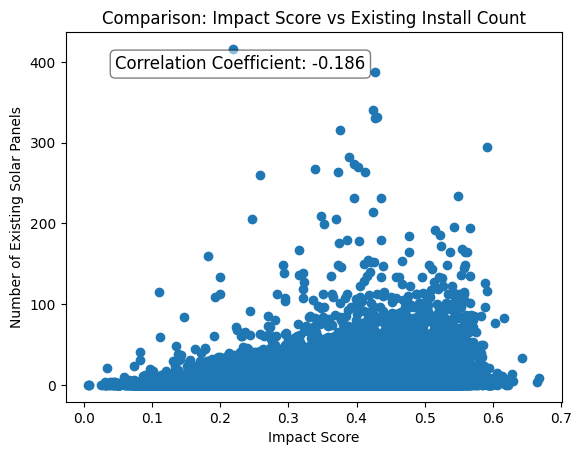

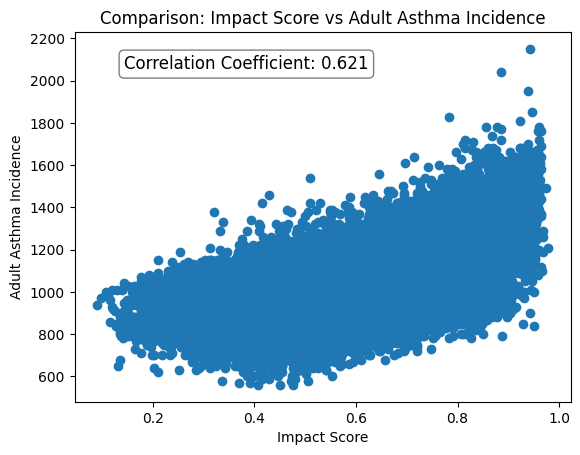

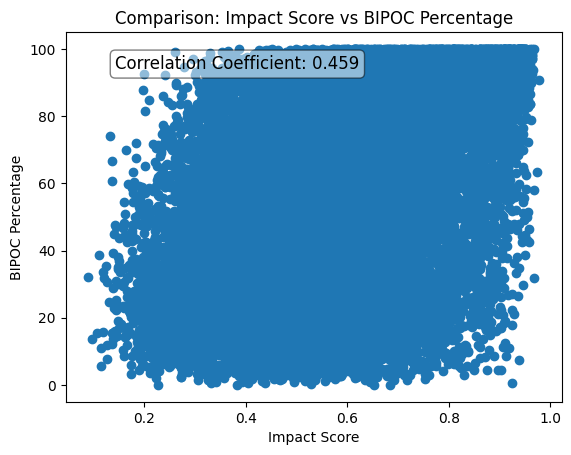

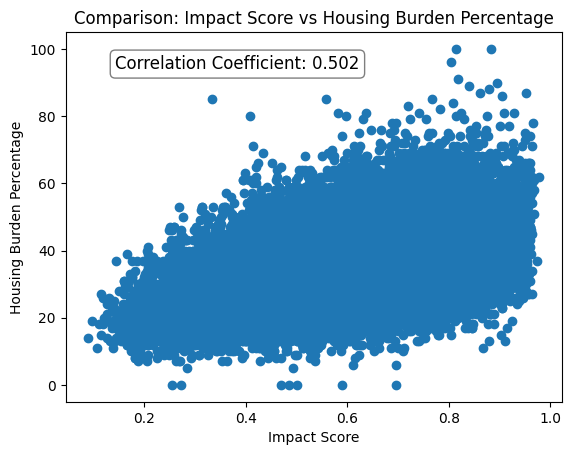

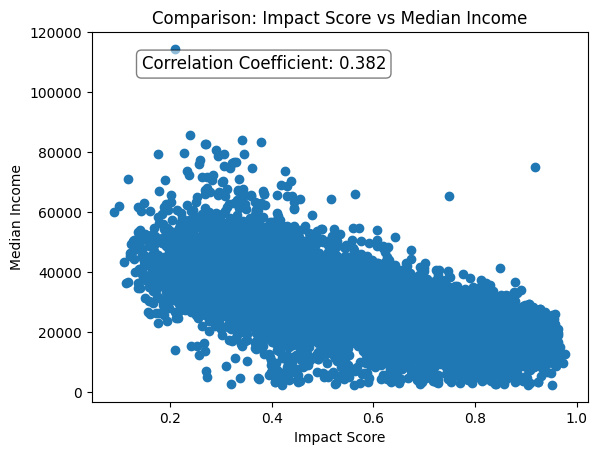

In [198]:
#Compare potential with Income, BIPOC, # of existing installs

# # Merge the mcda output data back into original dataframe
# mcda_data = merged_data.merge(mcda_output, left_index=True, right_index=True)

# Scatter plot of 'feasibility_score' vs 'existing_install_count'
plt.scatter(mcda_output['feasibility_score'], cleaned_data['existing_installs_count'])
plt.xlabel('Impact Score')
plt.ylabel('Number of Existing Solar Panels')
plt.title('Comparison: Impact Score vs Existing Install Count')
correlation_coefficient = mcda_output['impact_score'].corr(cleaned_data['existing_installs_count'])
# Annotate the plot with the correlation coefficient
plt.annotate(f"Correlation Coefficient: {correlation_coefficient:.3f}",
             xy=(0.1, 0.9),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.show()

plt.scatter(mcda_output['impact_score'], cleaned_data['Current asthma among adults aged greater than or equal to 18 years'])
plt.xlabel('Impact Score')
plt.ylabel('Adult Asthma Incidence')
plt.title('Comparison: Impact Score vs Adult Asthma Incidence')
correlation_coefficient = mcda_output['impact_score'].corr(cleaned_data['Current asthma among adults aged greater than or equal to 18 years'])
# Annotate the plot with the correlation coefficient
plt.annotate(f"Correlation Coefficient: {correlation_coefficient:.3f}",
             xy=(0.1, 0.9),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()


# Scatter plot of 'impact_score' vs 'bipoc_percent'
plt.scatter(mcda_output['impact_score'], cleaned_data['bipoc_percent'])
plt.xlabel('Impact Score')
plt.ylabel('BIPOC Percentage')
plt.title('Comparison: Impact Score vs BIPOC Percentage')
correlation_coefficient = mcda_output['impact_score'].corr(cleaned_data['bipoc_percent'])
plt.annotate(f"Correlation Coefficient: {correlation_coefficient:.3f}",
             xy=(0.1, 0.9),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()


plt.scatter(mcda_output['impact_score'], cleaned_data['Housing burden (percent)'])
plt.xlabel('Impact Score')
plt.ylabel('Housing Burden Percentage')
plt.title('Comparison: Impact Score vs Housing Burden Percentage')
correlation_coefficient = mcda_output['impact_score'].corr(cleaned_data['Housing burden (percent)'])
plt.annotate(f"Correlation Coefficient: {correlation_coefficient:.3f}",
             xy=(0.1, 0.9),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()

# Scatter plot of 'impact_score' vs 'median_income'
plt.scatter(mcda_output['impact_score'], cleaned_data['median_income'])
plt.xlabel('Impact Score')
plt.ylabel('Median Income')
plt.title('Comparison: Impact Score vs Median Income')
correlation_coefficient = mcda_output['feasibility_score'].corr(cleaned_data['median_income'])
plt.annotate(f"Correlation Coefficient: {correlation_coefficient:.3f}",
             xy=(0.1, 0.9),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()